In [43]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#from mlxtend.plotting import plot_confusion_matrix

RANDOM_SEED = 2021

%matplotlib inline

df = pd.read_csv('datasets/training_data.csv',encoding='cp1252')
teste = pd.read_csv('datasets/test_data.csv',encoding='cp1252')

ordem = {'None':0, 'Low':1, 'Medium':2, 'High':3, 'Very_High':4}

del df['AVERAGE_PRECIPITATION']
del teste['AVERAGE_PRECIPITATION']
df['AVERAGE_CLOUDINESS'].fillna(method='bfill',inplace=True)
df['AVERAGE_RAIN'].fillna(method='bfill',inplace=True)
df.dropna(inplace=True)

#Preparação para colocar nos modelos
X = df.drop(['AVERAGE_SPEED_DIFF'],axis=1)
y = df['AVERAGE_SPEED_DIFF'].to_frame()
Y = df['AVERAGE_SPEED_DIFF'].map(ordem)#.to_frame()
#yMLP = df['AVERAGE_SPEED_DIFF'].to_frame()
X_test = teste

city = LabelEncoder()
date = LabelEncoder()
luminosity = LabelEncoder()
cloudiness = LabelEncoder()
rain = LabelEncoder()
city_t = LabelEncoder()
date_t = LabelEncoder()
luminosity_t = LabelEncoder()
cloudiness_t = LabelEncoder()
rain_t = LabelEncoder()
#avg_speed_diff_yMLP = LabelEncoder()

X['city_name_n'] = city.fit_transform(X['city_name'])
X['record_date_n'] = date.fit_transform(X['record_date'])
X['LUMINOSITY_n'] = luminosity.fit_transform(X['LUMINOSITY'])
X['AVERAGE_CLOUDINESS_n'] = cloudiness.fit_transform(X['AVERAGE_CLOUDINESS'])
X['AVERAGE_RAIN_n'] = rain.fit_transform(X['AVERAGE_RAIN'])

X_test['city_name_n'] = city_t.fit_transform(X_test['city_name'])
X_test['record_date_n'] = date_t.fit_transform(X_test['record_date'])
X_test['LUMINOSITY_n'] = luminosity_t.fit_transform(X_test['LUMINOSITY'])
X_test['AVERAGE_CLOUDINESS_n'] = cloudiness_t.fit_transform(X_test['AVERAGE_CLOUDINESS'])
X_test['AVERAGE_RAIN_n'] = rain_t.fit_transform(X_test['AVERAGE_RAIN'])

#yMLP['AVERAGE_SPEED_DIFF_n'] = avg_speed_diff_yMLP.fit_transform(yMLP['AVERAGE_SPEED_DIFF'])

#yMLP_n = yMLP.drop(['AVERAGE_SPEED_DIFF'], axis=1)

X_n = X.drop(['city_name', 'record_date', 'LUMINOSITY', 'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN'],axis=1)
X_test_n = X_test.drop(['city_name', 'record_date', 'LUMINOSITY', 'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN'],axis=1)

def round_pred(pred,predictions):
    for n in pred:
        n = int(round(n))
        if n == 0:
            predictions.append('None')
        elif n == 1:
            predictions.append('Low')
        elif n == 2:
            predictions.append('Medium')
        elif n == 3:
            predictions.append('High')
        else:
            predictions.append('Very_High')


In [2]:
df.columns

Index(['city_name', 'record_date', 'AVERAGE_SPEED_DIFF',
       'AVERAGE_FREE_FLOW_SPEED', 'AVERAGE_TIME_DIFF',
       'AVERAGE_FREE_FLOW_TIME', 'LUMINOSITY', 'AVERAGE_TEMPERATURE',
       'AVERAGE_ATMOSP_PRESSURE', 'AVERAGE_HUMIDITY', 'AVERAGE_WIND_SPEED',
       'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN'],
      dtype='object')

In [3]:
df.head()

,city_name,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_RAIN
0,Porto,2019-08-29 07:00:00,Medium,41.5,11.5,71.4,LIGHT,15.0,1019.0,100.0,3.0,céu claro,chuva fraca
1,Porto,2018-08-10 14:00:00,High,41.7,48.3,87.4,LIGHT,21.0,1021.0,53.0,5.0,céu claro,chuva fraca
2,Porto,2019-09-01 16:00:00,High,38.6,38.4,85.2,LIGHT,26.0,1014.0,61.0,4.0,céu claro,chuva fraca
3,Porto,2019-02-26 11:00:00,High,37.4,61.0,94.1,LIGHT,18.0,1025.0,48.0,4.0,céu claro,chuva fraca
4,Porto,2019-06-06 12:00:00,Medium,41.6,50.4,77.0,LIGHT,15.0,1008.0,82.0,10.0,nuvens dispersas,chuva fraca


In [4]:
df.describe()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED
count,6802.000000,6802.000000,6802.000000,6802.000000,6802.000000,6802.000000,6802.000000
mean,40.662820,25.644575,81.142782,16.195972,1017.382388,80.091517,3.058365
std,4.120387,33.526502,8.293898,5.164366,5.751973,18.233642,2.138831
min,30.500000,0.000000,46.400000,0.000000,985.000000,14.000000,0.000000
25%,37.600000,2.225000,75.400000,13.000000,1015.000000,70.000000,1.000000
50%,40.700000,12.200000,82.400000,16.000000,1017.000000,83.000000,3.000000
75%,43.500000,36.200000,87.400000,19.000000,1021.000000,93.000000,4.000000
max,55.900000,296.500000,112.000000,35.000000,1033.000000,100.000000,14.000000


In [5]:
df.isna().any()

city_name                  False
record_date                False
AVERAGE_SPEED_DIFF         False
AVERAGE_FREE_FLOW_SPEED    False
AVERAGE_TIME_DIFF          False
AVERAGE_FREE_FLOW_TIME     False
LUMINOSITY                 False
AVERAGE_TEMPERATURE        False
AVERAGE_ATMOSP_PRESSURE    False
AVERAGE_HUMIDITY           False
AVERAGE_WIND_SPEED         False
AVERAGE_CLOUDINESS         False
AVERAGE_RAIN               False
dtype: bool

In [6]:
df[df.duplicated(['record_date'], keep=False)]

,city_name,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_RAIN


In [7]:
df.groupby(by=['LUMINOSITY']).agg(pd.Series.mode)

,city_name,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_RAIN
LUMINOSITY,,,,,,,,,,,,
DARK,Porto,"[2018-07-24 21:00:00, 2018-07-25 00:00:00, 201...",None,41.9,0.0,87.0,17.0,1017.0,100.0,1.0,céu claro,chuva fraca
LIGHT,Porto,"[2018-07-24 15:00:00, 2018-07-24 16:00:00, 201...",Medium,40.0,0.0,87.4,20.0,1016.0,100.0,3.0,céu claro,chuva fraca
LOW_LIGHT,Porto,"[2018-07-25 06:00:00, 2018-07-25 20:00:00, 201...",None,40.8,0.0,85.7,18.0,1016.0,100.0,2.0,céu claro,chuva fraca


<AxesSubplot:xlabel='AVERAGE_WIND_SPEED', ylabel='AVERAGE_SPEED_DIFF'>

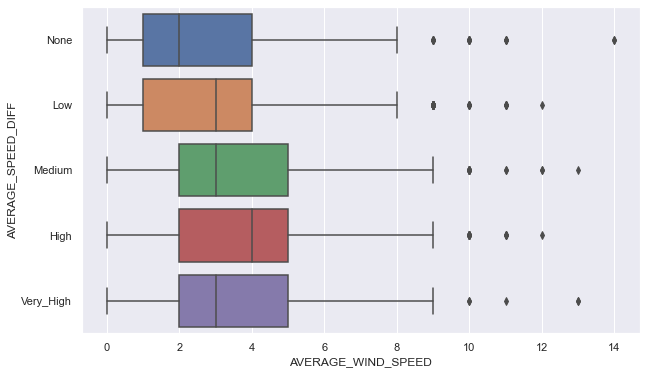

In [8]:
sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x=df['AVERAGE_WIND_SPEED'],y=df['AVERAGE_SPEED_DIFF'],order=ordem)

<AxesSubplot:xlabel='AVERAGE_RAIN', ylabel='count'>

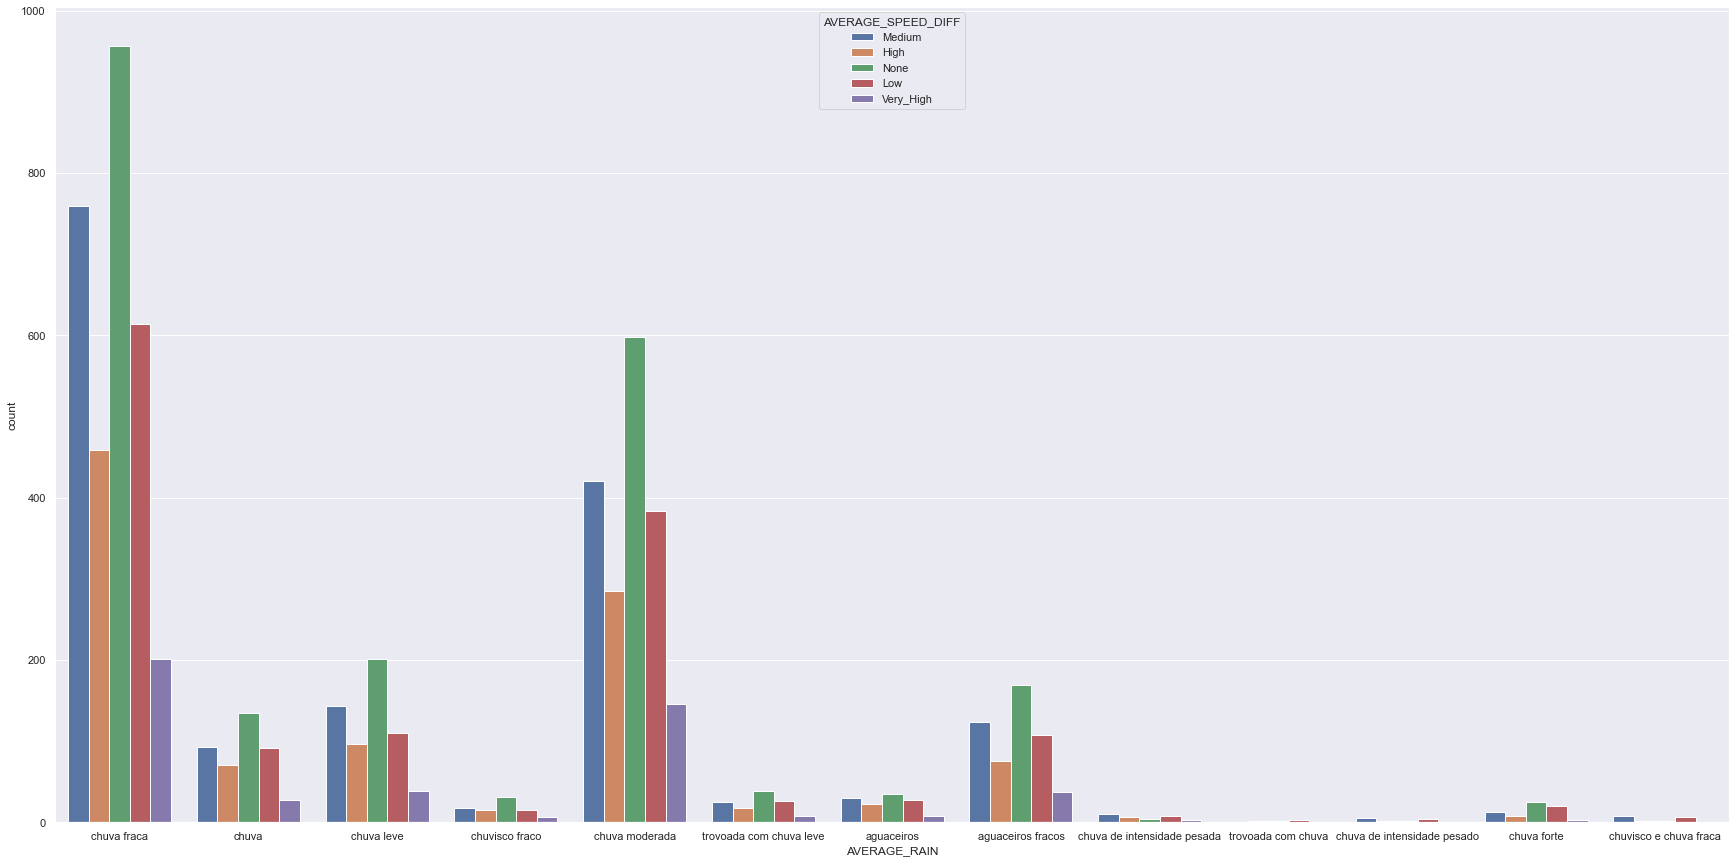

In [9]:
sns.set(rc={'figure.figsize':(30,15)})
sns.countplot(x=df['AVERAGE_RAIN'],hue=df['AVERAGE_SPEED_DIFF'])

<AxesSubplot:xlabel='AVERAGE_SPEED_DIFF', ylabel='Count'>

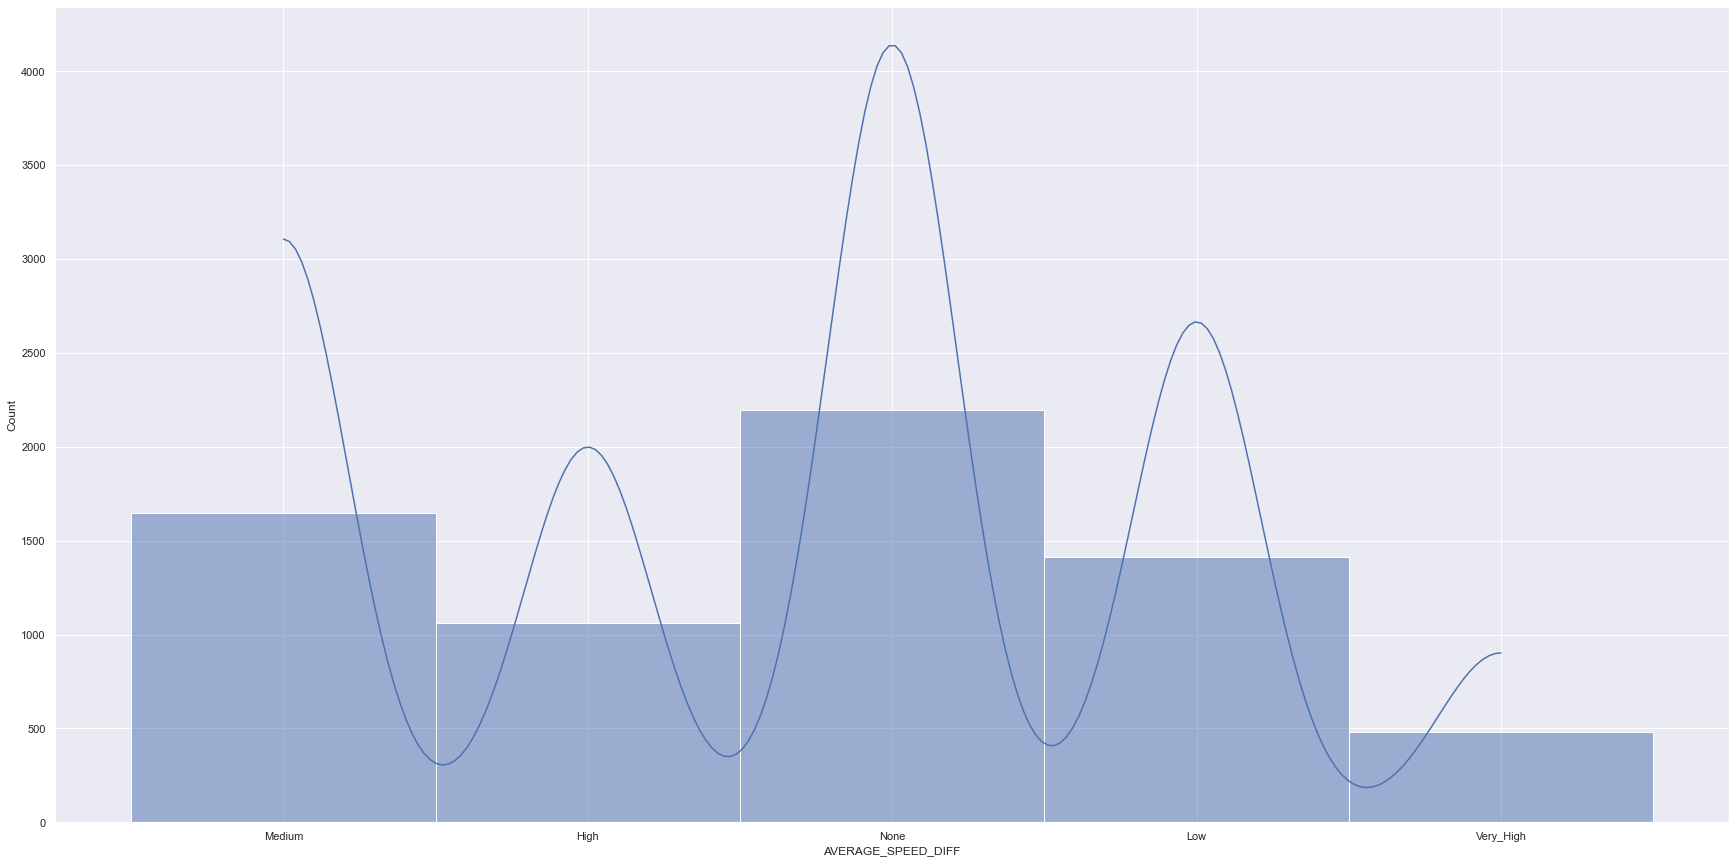

In [10]:
sns.histplot(df['AVERAGE_SPEED_DIFF'],kde=True)

In [20]:
#Decision Tree Classifier

#X_train,X_test,y_train,y_test = train_test_split(X_n,y, test_size=0.2, random_state=2)

dtc = DecisionTreeClassifier(random_state= RANDOM_SEED)
dtc.fit(X_n,y)

predictions = dtc.predict(X_test_n)
predictions

#accuracy_score(y_test, predictions)

# cm = confusion_matrix(y_test, predictions)
# plt.figure()
# plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
# plt.title("Decision Tree Model - Confusion Matrix")
# plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
# plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
# plt.show()

array(['None', 'Low', 'None', ..., 'None', 'Very_High', 'Low'],
      dtype=object)

In [12]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_n,Y)

pred = lr.predict(X_test_n)
predictions = []
round_pred(pred,predictions)
        
predictions

['None',
 'Low',
 'None',
 'Medium',
 'Low',
 'Medium',
 'Low',
 'Low',
 'Low',
 'Medium',
 'None',
 'Low',
 'Medium',
 'Medium',
 'Medium',
 'High',
 'None',
 'Medium',
 'Low',
 'Low',
 'None',
 'None',
 'Low',
 'None',
 'Medium',
 'Low',
 'Medium',
 'Low',
 'None',
 'Very_High',
 'Low',
 'Low',
 'Very_High',
 'Low',
 'Low',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'None',
 'Low',
 'None',
 'Medium',
 'Very_High',
 'Medium',
 'Low',
 'Low',
 'None',
 'Low',
 'Low',
 'Low',
 'Medium',
 'High',
 'Medium',
 'None',
 'Medium',
 'High',
 'High',
 'Very_High',
 'None',
 'None',
 'Low',
 'Low',
 'Low',
 'Very_High',
 'None',
 'Very_High',
 'Low',
 'Medium',
 'Very_High',
 'None',
 'Low',
 'Low',
 'Low',
 'Very_High',
 'Medium',
 'Low',
 'None',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Very_High',
 'None',
 'None',
 'Low',
 'Low',
 'Medium',
 'Low',
 'Medium',
 'Medium',
 'None',
 'None',
 'High',
 'Medium',
 'None',
 'High',
 'None',
 'None',
 'High',
 'Medium',
 'Low',
 'None',
 'None',
 'Medi

In [13]:
#Logistic Regression
logr = LogisticRegression(max_iter=10000)
logr.fit(X_n,Y)

pred = logr.predict(X_test_n)
predictions = []
round_pred(pred,predictions)

#predictions

In [14]:
#SVC
#print(X_n.info())
model = LinearSVC(dual=False)
model.fit(X_n,np.ravel(y))

predictions = model.predict(X_test_n)
for x in predictions:
    print(x)

None
Low
None
Medium
None
Medium
Very_High
Medium
None
Medium
None
None
Medium
Medium
Medium
High
None
Medium
Low
None
None
None
Low
None
Medium
High
Medium
None
None
High
None
Low
Very_High
Medium
None
None
Low
Medium
Medium
None
None
None
Medium
Very_High
High
Low
Medium
None
Medium
None
Low
Medium
High
Medium
None
Very_High
Very_High
High
Very_High
None
None
Very_High
None
Medium
High
None
High
Low
Medium
High
None
Medium
Medium
Medium
High
Very_High
None
None
Medium
Very_High
Low
Medium
Very_High
None
None
Medium
None
Medium
None
Very_High
Medium
None
None
Medium
Medium
None
High
None
None
Very_High
Medium
Medium
None
None
Medium
Medium
Very_High
Medium
Medium
None
Low
None
High
High
None
Low
Medium
None
None
Very_High
None
None
High
Low
Medium
High
Low
Very_High
Medium
None
Medium
None
Medium
High
Very_High
Medium
Medium
Medium
Very_High
Medium
None
Medium
High
High
Low
Medium
High
High
Medium
None
Medium
None
None
High
Very_High
Medium
Medium
High
Medium
Low
Medium
High
None
Medi

In [15]:
#K-Means
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_n,Y)

predictions = kmeans.fit_predict(X_test_n)
predictions


array([2, 2, 0, ..., 0, 2, 3])

<AxesSubplot:>

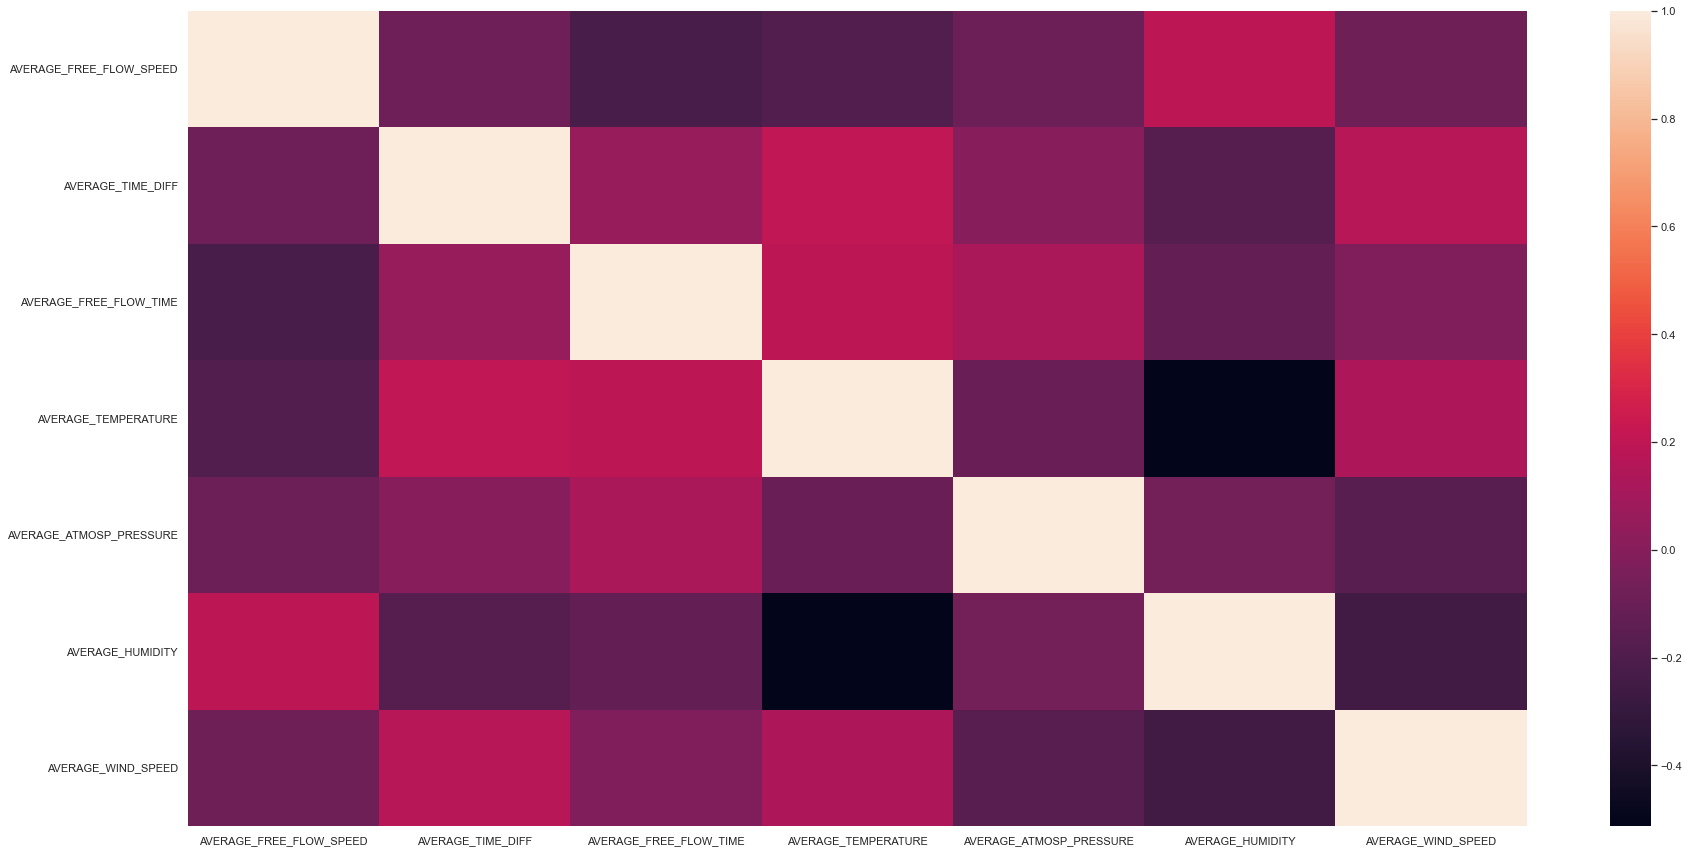

In [17]:
sns.heatmap(df.corr())

In [56]:
#scaler_X = MinMaxScaler(feature_range=(0,1)).fit(X_n)
#scaler_yMLP = MinMaxScaler(feature_range=(0,1)).fit(yMLP_n)
#X_scaled = pd.DataFrame(scaler_X.transform(X_n[X_n.columns]), columns = X_n.columns)
#yMLP_scaled = pd.DataFrame(scaler_yMLP.transform(yMLP_n[yMLP_n.columns]), columns = yMLP_n.columns)

#def build_model(activation='relu', learning_rate=0.01):
#    model = Sequential()
#    model.add(Dense(16, input_dim=5, activation = activation))
#    model.add(Dense(8, activation=activation))
#    model.add(Dense(1, activation='relu'))
    
#    model.compile(
#        loss = 'mae',
#        optimizer = tf.optimizers.Adam(learning_rate),
#        metrics = ['mae', 'mse'])
#    return model

#X_train, X_test, y_train, y_test = train_test_split(X_scaled, yMLP_scaled, test_size=0.2, random_state=RANDOM_SEED)

#TUNING_DICT = {
#    'activation' : ['relu', 'sigmoid'],
#    'learning_rate' : [0.01, 0.001]
#}

#kf = KFold(n_splits=5, shuffle=True, random_state = RANDOM_SEED)

#model = KerasRegressor(build_fn=build_model, epochs=20, batch_size=32)
#grid_search = GridSearchCV(estimator = model,
                          param_grid = TUNING_DICT,
                          cv = kf,
                          scoring = 'neg_mean_absolute_error',
                          refit = 'True',
                          verbose = 1)
#grid_search.fit(X_train, y_train, validation_split=0.2, verbose=1)

In [16]:
submission = open("submissions/submission6.csv", "w", newline='')
writer = csv.writer(submission)
writer.writerow(['RowId', 'Speed_Diff'])
rowId = list(range(0, 1500))
for i in range(1500):
    writer.writerow([rowId[i]+1, predictions[i]])

submission.close()
    